# Problem 2

What about uniform distribution of characters ? Compute the loss and maybe try optimising that NN

# Results:

- Initialization of the character embeddings **very important**. Only a random init gives the best results
- All zeros give the worst results

In [1]:
with open("../names.txt", 'r') as file:
    names = file.read().splitlines()

len(names)

32033

In [2]:
chars = sorted(list(set("".join(name for name in names))))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [3]:
stoi, itos = {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, ch in enumerate(chars):
    stoi[ch] = i + 1
    itos[i + 1] = ch

len(stoi), len(itos)

(27, 27)

In [15]:
from sklearn.model_selection import train_test_split  

random_state = 42
names_train, names_temp = train_test_split(names, test_size=0.2, random_state=random_state,\
                                            shuffle=True)  
names_dev, names_test = train_test_split(names_temp, test_size=0.5, random_state=random_state,\
                                            shuffle=True)  

len(names_train), len(names_dev), len(names_test)

(25626, 3203, 3204)

In [4]:
import torch

def create_dataset(names, window_size=3):
    xs, ys = [], []

    for name in names:
        # print(name)
        name = ['.'] * window_size + list(name) + ['.']
        for i, ch in enumerate(name[window_size:]):
            x = [stoi[c] for c in name[i:i + window_size]]
            y = stoi[ch]
            # print(f"{x}-->{y}")
            xs.append(x)
            ys.append(y)

    xs = torch.Tensor(xs).long()
    ys = torch.Tensor(ys).long()

    return xs, ys

In [5]:
X, y = create_dataset(names)
X.shape, y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [8]:
y.dtype

torch.int64

In [18]:
X_train, y_train = create_dataset(names_train)
X_dev, y_dev = create_dataset(names_dev)
X_test, y_test = create_dataset(names_test)
X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape

(torch.Size([182497, 3]),
 torch.Size([182497]),
 torch.Size([22882, 3]),
 torch.Size([22882]),
 torch.Size([22767, 3]),
 torch.Size([22767]))

## Compute NLL in case of uniform distribution

In [12]:
logits = torch.ones((y.shape[0], len(stoi))).float() # create a uniform distribution (basically getting same o/p)
logits.shape

torch.Size([228146, 27])

In [13]:
logits.dtype

torch.float32

In [14]:
import torch.nn.functional as F

nll_uniform = F.cross_entropy(logits, y).item()
nll_uniform


3.295837163925171

## Identify the initialization for the uniform dist

### Idea 1: Set all weights to 0

In [16]:
def create_zero_model(emb_dim, hidden_size, window_size, vocab_size, direct=False):
    # Using paper vocab
    C = torch.zeros((vocab_size, emb_dim), requires_grad=True).float()
    
    H = torch.zeros((emb_dim * window_size, hidden_size), requires_grad=True).float()
    d = torch.zeros(hidden_size, requires_grad=True).float()

    U = torch.zeros((hidden_size, vocab_size), requires_grad=True).float()
    b = torch.zeros(vocab_size, requires_grad=True).float()

    params = [C, H, d, U, b]

    if direct:
        W = torch.zeros((emb_dim * window_size, vocab_size), requires_grad=True).float()
        params.append(W)

    return params

In [17]:
def forward(batch, params, direct=False):
    if direct:
        C, H, d, U, b, W = params
    else:
        C, H, d, U, b = params

    inp = C[batch].view((batch.shape[0], -1))
    h = torch.tanh(inp @ H + d)
    logits = h @ U + b

    if direct:
        logits += inp @ W

    return logits

In [19]:
def get_loss(params, X, y, direct=False):
    logits = forward(X, params, direct)
    nll = F.cross_entropy(logits, y)

    return nll.item()    

In [20]:
zero_model = create_zero_model(emb_dim=10, hidden_size=400, window_size=3,\
                                 vocab_size=len(stoi), direct=True)

In [21]:
loss = get_loss(zero_model, X, y, True)
loss

3.295837163925171

In [22]:
train_loss = get_loss(zero_model, X_train, y_train, True)
train_loss

3.29583740234375

In [24]:
dev_loss = get_loss(zero_model, X_dev, y_dev, True)
dev_loss

3.295837163925171

In [23]:
test_loss = get_loss(zero_model, X_test, y_test, True)
test_loss

3.295836925506592

### Idea 2: Minimum no. of parameters to be set to 0.

For this, we set `H` and `W` to 0 and all others as `torch.ones()` times anything random

In [72]:
def create_uniform_model(emb_dim, hidden_size, window_size, vocab_size, direct=False):
    g = torch.Generator().manual_seed(2147483647)

    # Using paper vocab
    C = torch.randn((vocab_size, emb_dim), dtype=torch.float32,\
                     generator=g)
    
    H = torch.zeros((emb_dim * window_size, hidden_size)).float()
    d = torch.randn(hidden_size, dtype=torch.float32, generator=g)

    U = torch.randn((hidden_size, 1), dtype=torch.float32, generator=g).repeat(1, vocab_size)
    b = torch.full((vocab_size,), torch.randn(1, generator=g).item()).float()

    params = [C, H, d, U, b]

    if direct:
        W = torch.zeros((emb_dim * window_size, vocab_size)).float()
        params.append(W)

    for p in params:
        p.requires_grad = True
        
    return params

In [73]:
uniform_model = create_uniform_model(emb_dim=10, hidden_size=400, window_size=3,\
                                 vocab_size=len(stoi), direct=True)

In [74]:
loss = get_loss(uniform_model, X, y, True)
loss

3.295837163925171

In [75]:
train_loss = get_loss(uniform_model, X_train, y_train, True)
train_loss

3.29583740234375

In [76]:
dev_loss = get_loss(uniform_model, X_dev, y_dev, True)
dev_loss

3.295837163925171

In [77]:
test_loss = get_loss(uniform_model, X_test, y_test, True)
test_loss

3.295836925506592

### Another idea w/o zeros

In [60]:
def create_uniform_model_idea2(emb_dim, hidden_size, window_size, vocab_size, direct=False):
    g = torch.Generator().manual_seed(2147483647)

    # Using paper vocab
    C = torch.randn((1, emb_dim), dtype=torch.float32, generator=g).\
    repeat(vocab_size, 1)
    
    H = torch.randn((emb_dim * window_size, 1), dtype=torch.float32, generator=g,\
                     ).repeat(1, hidden_size).float()
    d = torch.full((hidden_size,), torch.randn(1, generator=g).item()).float()

    U = torch.randn((hidden_size, 1), dtype=torch.float32, generator=g).\
        repeat(1, vocab_size)
    b = torch.full((vocab_size,), torch.randn(1, generator=g).item()).float()

    params = [C, H, d, U, b]

    if direct:
        W = torch.randn((emb_dim * window_size, 1), dtype=torch.float32, generator=g,\
                     ).repeat(1, vocab_size).float()
        params.append(W)

    for p in params:
        p.requires_grad = True
        
    return params

In [61]:
uniform_model2 = create_uniform_model_idea2(emb_dim=10, hidden_size=400, window_size=3,\
                                 vocab_size=len(stoi), direct=True)

In [62]:
loss = get_loss(uniform_model2, X, y, True)
loss

3.295837163925171

In [63]:
train_loss = get_loss(uniform_model2, X_train, y_train, True)
train_loss

3.29583740234375

In [64]:
dev_loss = get_loss(uniform_model2, X_dev, y_dev, True)
dev_loss

3.295837163925171

In [65]:
test_loss = get_loss(uniform_model2, X_test, y_test, True)
test_loss

3.295836925506592

## Will training these models make any difference ?

In [66]:
import torch.nn.functional as F

def train(params, X, y, epochs, batch_size, lr_scheduler, direct=False):
    g = torch.Generator().manual_seed(2147483647)
    stepi, lossi = [], []

    for epoch in range(epochs):
        # set grads as None
        for p in params:
            p.grad = None

        # create minibatch
        ix = torch.randint(0, len(X), (batch_size, ), generator=g)
        batch = X[ix]

        # forward
        logits = forward(batch, params, direct)

        # loss compute
        nll = F.cross_entropy(logits, y[ix])

        # backward
        nll.backward()

        # update params
        for p in params:
            p.data -= lr_scheduler(epoch) * p.grad

        stepi.append(epoch)
        lossi.append(nll.log10().item())

    return stepi, lossi


In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

### Zero Model

In [55]:
stepi, lossi = train(zero_model, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=True)

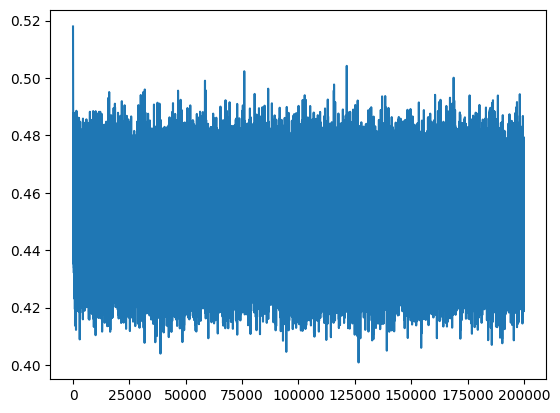

In [56]:
plt.plot(stepi, lossi)

In [57]:
train_loss = get_loss(zero_model, X_train, y_train, direct=True)
dev_loss = get_loss(zero_model, X_dev, y_dev, direct=True)
train_loss, dev_loss

(2.8226912021636963, 2.8195109367370605)

### Idea 1

In [78]:
stepi, lossi = train(uniform_model, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=True)

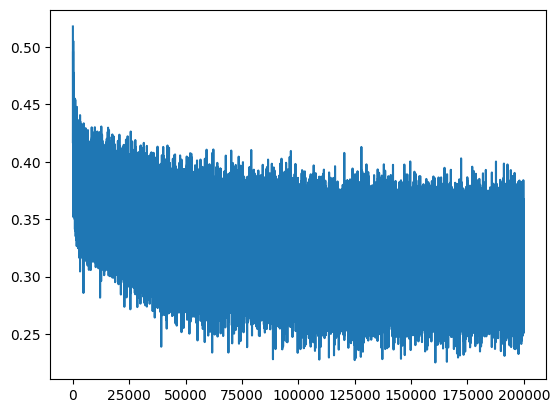

In [79]:
plt.plot(stepi, lossi)

In [80]:
train_loss = get_loss(uniform_model, X_train, y_train, direct=True)
dev_loss = get_loss(uniform_model, X_dev, y_dev, direct=True)
train_loss, dev_loss

(2.071765661239624, 2.116227149963379)

### Idea 2

In [68]:
stepi, lossi = train(uniform_model2, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=True)

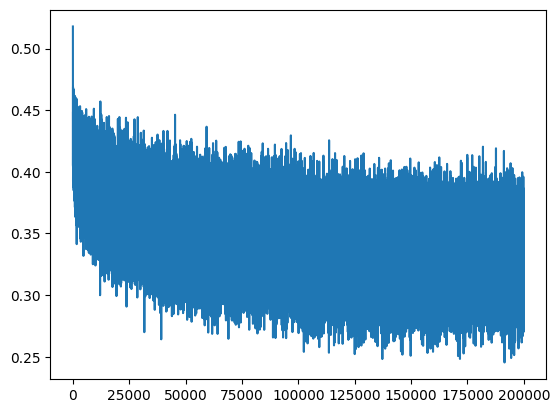

In [69]:
plt.plot(stepi, lossi)


In [71]:
train_loss = get_loss(uniform_model2, X_train, y_train, direct=True)
dev_loss = get_loss(uniform_model2, X_dev, y_dev, direct=True)
train_loss, dev_loss

(2.1587746143341064, 2.1719722747802734)